## Import Packages and Datasets

In [1]:
# Import packages
import scanpy as sc
from PIL.ImageColor import colormap
from jmespath.ast import projection

In [2]:
# Import Datasets

# Normal CellHint scRNA Dataset (Human Kidney)
## ~ 33k Genes
normal = sc.read_h5ad('/Volumes/CHAMPANERI/Databases/Human_Nor_Kidney_CellHint_scRNA.h5ad')

# Healthy and Injured Cell States and Niches in the Human Kidney ––– scRNA
## ~ 31k Genes
scRNA_ckd = sc.read_h5ad('/Volumes/CHAMPANERI/Databases/Human_Nor-CKD-AKF_scRNA.h5ad')

# Healthy and Injured Cell States and Niches in the Human Kidney ––– scRNA
## ~ 36k Genes
snRNA_ckd = sc.read_h5ad('/Volumes/CHAMPANERI/Databases/Human_Nor-CKD-AKF_snRNA.h5ad')

## Preprocessing of the Data and Quality Control
Based on: https://cellxgene.cziscience.com/docs/04__Analyze%20Public%20Data/4_2__Gene%20Expression%20Documentation/4_2_3__Gene%20Expression%20Data%20Processing

Steps Explained:
1. Cell Filtering: Removes cells expressing fewer than 500 genes. This step filters out low-quality cells, empty droplets, and debris.
2. Gene Filtering: Removes genes detected in fewer than 3 cells, eliminating technical noise and very rarely expressed genes.
3. Normalization: Scales gene expression values in each cell to a total count of 10,000 (1e4), correcting for differences in sequencing depth between cells.
4. Log Transformation: Applies a natural logarithm transformation (log(x+1)) to normalized data, stabilizing variance and making expression values more comparable.
5. Scaling: Standardizes each gene to zero mean and unit variance, capping maximum values at 10 to limit the influence of outliers. This prepares data for dimensionality reduction and clustering.

In [3]:
# Preprocessing of the Data

# Basic filtering
sc.pp.filter_cells(normal, min_genes=500, inplace=True)
sc.pp.filter_genes(normal, min_cells=3, inplace=True)

'''
Annotate the group of mitochondrial genes as 'mt'
Calculate QC metrics for further filtering

# normal.var["mt"] = normal.var_names.str.startswith("MT-")
# sc.pp.calculate_qc_metrics(normal, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)


Violin plots of QC metrics -- give us information about how to proceed with filtering
Show NO mitochondrial genes and no cells with high total counts -- No further filtering
Uncomment to see the plots

# sc.pl.violin(normal, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
# sc.pl.scatter(normal, x="total_counts", y="pct_counts_mt")
# sc.pl.scatter(normal, x="total_counts", y="n_genes_by_counts")
'''

# Normalize, log-transform, and scale the data
sc.pp.normalize_total(normal, target_sum=1e4)
sc.pp.log1p(normal)

# Identify and plot highly-variable genes
sc.pp.highly_variable_genes(normal, min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pl.highly_variable_genes(normal)

normal.raw = normal.copy()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Generate UMAP and PCA

> Can use CellTypist to reannotate the cell types for the UMAP

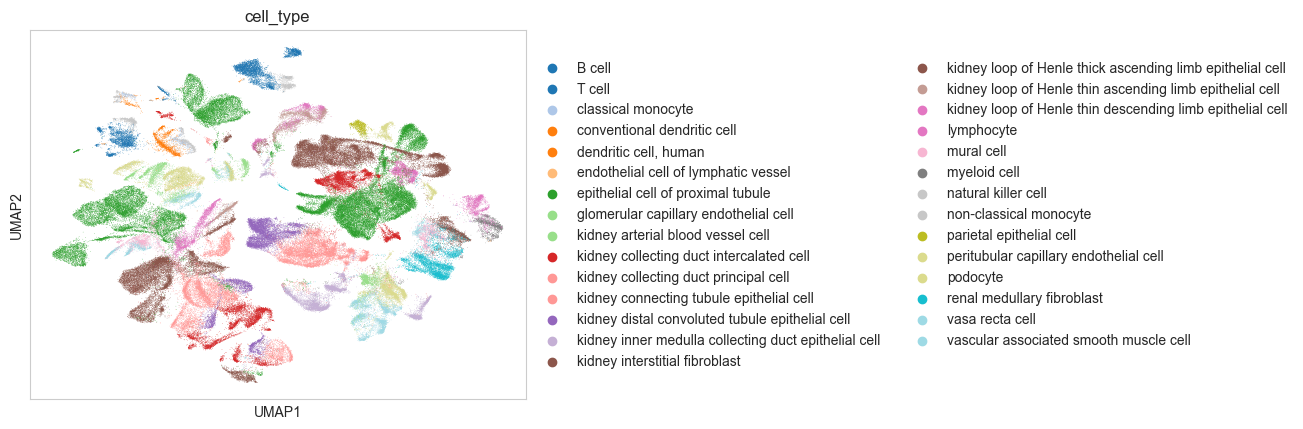

In [30]:
# Principal Component Analysis (PCA)
sc.pp.pca(normal, svd_solver="arpack")
# Plot the PCA -- Uncomment to see the plot
# sc.pl.pca(normal)
# sc.pl.pca_variance_ratio(normal, log=True)

# Generate UMAP
sc.pp.neighbors(normal)
sc.tl.umap(normal)

# Leiden clustering
sc.tl.leiden(normal, flavor='igraph', n_iterations=2)
sc.pl.umap(normal,
           color=['cell_type']
) # Looks better with dark background


# Dendrogram Key for downstream visualization
sc.tl.dendrogram(normal, groupby='cell_type')
sc.tl.dendrogram(normal, groupby='tissue')

## Plotting the Data

### Group the cell types into broader categories for better visualization

- Groups are defined based on the cell types in the dataset

#### Define the groups for cell types
> 'cell_type_group':
- Myeloid Cells: myeloid cell, classical monocyte, non-classical monocyte
- Kidney Cells: kidney distal convoluted tubule epithelial cell, epithelial cell of proximal tubule, kidney connecting tubule epithelial cell, kidney loop of Henle thick ascending limb epithelial cell, kidney collecting duct intercalated cell, kidney collecting duct principal cell, kidney inner medulla collecting duct epithelial cell, kidney loop of Henle thin descending limb epithelial cell, kidney loop of Henle thin ascending limb epithelial cell
- Endothelial Cells: peritubular capillary endothelial cell, glomerular capillary endothelial cell, vasa recta cell, kidney arterial blood vessel cell, endothelial cell of lymphatic vessel
- Fibroblasts: kidney interstitial fibroblast, renal medullary fibroblast
- Epithelial Cells: podocyte, parietal epithelial cell
- Immune Cells: lymphocyte, dendritic cell, human, conventional dendritic cell, natural killer cell, B cell, T cell
- Smooth Muscle Cells: vascular associated smooth muscle cell, mural cell
- Other: Remaining cell types


In [31]:
# List all the cell types in the dataset
cell_types = normal.obs['cell_type'].unique()
print("Cell Types:")
for cell_type in cell_types:
    print(f"  {cell_type}")

# Define the groups for cell types
cell_type_groups = {
    'Myeloid Cells': ['myeloid cell', 'classical monocyte', 'non-classical monocyte'],
    'Kidney Cells': ['kidney distal convoluted tubule epithelial cell', 'epithelial cell of proximal tubule',
                     'kidney connecting tubule epithelial cell', 'kidney loop of Henle thick ascending limb epithelial cell',
                     'kidney collecting duct intercalated cell', 'kidney collecting duct principal cell',
                     'kidney inner medulla collecting duct epithelial cell', 'kidney loop of Henle thin descending limb epithelial cell',
                     'kidney loop of Henle thin ascending limb epithelial cell'],
    'Endothelial Cells': ['peritubular capillary endothelial cell', 'glomerular capillary endothelial cell',
                          'vasa recta cell', 'kidney arterial blood vessel cell', 'endothelial cell of lymphatic vessel'],
    'Fibroblasts': ['kidney interstitial fibroblast', 'renal medullary fibroblast'],
    'Epithelial Cells': ['podocyte', 'parietal epithelial cell'],
    'Immune Cells': ['lymphocyte', 'dendritic cell, human', 'conventional dendritic cell', 'natural killer cell', 'B cell', 'T cell'],
    'Smooth Muscle Cells': ['vascular associated smooth muscle cell', 'mural cell']
}

# Map cell types to groups
normal.obs['cell_type_group'] = 'Other'
for group, cell_types in cell_type_groups.items():
    normal.obs.loc[normal.obs['cell_type'].isin(cell_types), 'cell_type_group'] = group

# Check the new amount of cell types
cell_type_groups = normal.obs['cell_type_group'].unique()
print("Cell Type Groups:")
for group in cell_type_groups:
    print(f"  {group}")

Cell Types:
  kidney distal convoluted tubule epithelial cell
  epithelial cell of proximal tubule
  lymphocyte
  kidney connecting tubule epithelial cell
  kidney loop of Henle thick ascending limb epithelial cell
  kidney collecting duct intercalated cell
  peritubular capillary endothelial cell
  kidney interstitial fibroblast
  kidney collecting duct principal cell
  myeloid cell
  glomerular capillary endothelial cell
  podocyte
  vasa recta cell
  kidney arterial blood vessel cell
  kidney inner medulla collecting duct epithelial cell
  endothelial cell of lymphatic vessel
  parietal epithelial cell
  renal medullary fibroblast
  kidney loop of Henle thin descending limb epithelial cell
  mural cell
  vascular associated smooth muscle cell
  kidney loop of Henle thin ascending limb epithelial cell
  conventional dendritic cell
  dendritic cell, human
  natural killer cell
  B cell
  T cell
  classical monocyte
  non-classical monocyte
Cell Type Groups:
  Kidney Cells
  Immune Cel

#### Expression profile of complement pattern recognition molecules
- Complement PRMs are a group of proteins that are involved in the recognition of pathogens and apoptotic cells
- Use gene names to find genes

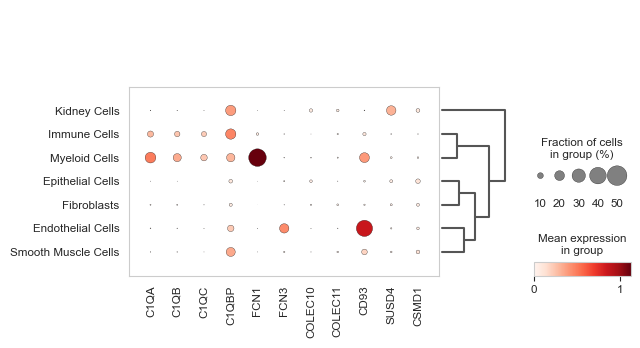

In [32]:
# Define the gene set for plotting
complement_prms = ['C1QA', 'C1QB', 'C1QC', 'C1QBP', 'FCN1', 'FCN3', 'COLEC10', 'COLEC11', 'CD93', 'SUSD4', 'CSMD1']
# Plot the expression of complement PRMs as a dot plot
sc.pl.DotPlot(normal, complement_prms, groupby='cell_type_group', gene_symbols='feature_name').add_dendrogram(show=True,size=0.9).show()

# Draft Figures
> Expect no documentations for the figures
>
> Will be updated in the final version
>
> More information can be found in the LaTeX Draft v01.pdf file

In [ ]:
# Gene Dictionaries
complement_genes = []

In [ ]:
# Comprehensive Heatmap


# WORK IN PROGRESS and TESTING
## Generate Python Scripts for batch running